# Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader

In [20]:
no_users = 50
seq_len = 14

var_1 = np.random.uniform(0,1,no_users*seq_len)
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, seq_len)
corr_factors = 1+s

data = {'date': np.tile(np.arange(datetime(2021,3,1), datetime(2021,3,15), timedelta(days=1)).astype(datetime), no_users), 
        'user_id': np.repeat(np.array([range(no_users)]),seq_len),
        'playtime': var_1,
        'logins': var_1 * np.repeat(corr_factors,no_users)}
df = pd.DataFrame.from_dict(data)
df.head()

,date,user_id,playtime,logins
0,2021-03-01,0,0.784616,0.849608
1,2021-03-02,0,0.523554,0.566921
2,2021-03-03,0,0.111045,0.120243
3,2021-03-04,0,0.809207,0.876235
4,2021-03-05,0,0.388637,0.420829


In [21]:
# as we want our model to be able to learn and correctly predict, we need to give the output a pattern. If the mean of playtime over the 14 days for a specific user is higher than 0.5, we'll flag it as 1, otherwise as 0
df['target']=np.repeat(np.where(df.groupby('user_id')['playtime'].mean()>0.5,1,0),seq_len)
df.describe()

,user_id,playtime,logins,target
count,700.000000,700.000000,700.000000,700.000000
mean,24.500000,0.491938,0.499961,0.500000
std,14.441189,0.293680,0.301129,0.500358
min,0.000000,0.000067,0.000061,0.000000
25%,12.000000,0.243478,0.249754,0.000000
50%,24.500000,0.477808,0.491220,0.500000
75%,37.000000,0.750654,0.760012,1.000000
max,49.000000,0.999869,1.113977,1.000000


In [22]:
features=['playtime', 'logins']

x = np.swapaxes(df[features].values.reshape(no_users, seq_len, -1),1,2)
x[:2]

array([[[0.78461593, 0.52355394, 0.11104516, 0.80920666, 0.38863715,
         0.29040549, 0.63918328, 0.38555694, 0.17945959, 0.34505064,
         0.34769526, 0.63634129, 0.97212073, 0.27127491],
        [0.84960771, 0.56692127, 0.12024332, 0.87623534, 0.42082897,
         0.31446053, 0.69212848, 0.41749362, 0.1943247 , 0.37363208,
         0.37649576, 0.68905109, 1.05264401, 0.29374531]],

       [[0.03574961, 0.88331648, 0.9760104 , 0.40662349, 0.76478714,
         0.39173782, 0.89112002, 0.53478426, 0.75512506, 0.31273387,
         0.71166395, 0.74982573, 0.91545131, 0.15607125],
        [0.03871085, 0.95648387, 1.05685587, 0.44030517, 0.82813644,
         0.42418648, 0.9649338 , 0.57908183, 0.81767402, 0.33863843,
         0.77061292, 0.81193574, 0.99128052, 0.16899904]]])

In [23]:
y = df.groupby('user_id').target.max().values
y[:3]

array([0, 1, 1])

In [24]:
x.shape, y.shape

((50, 2, 14), (50,))

## to dataset and dataloader

In [25]:
def create_datasets(data, target, train_size, valid_pct=0.1, seed=None):
    """Converts NumPy arrays into PyTorch datsets."""
    
    sz = train_size
    idx = np.arange(sz)
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct, random_state=seed)
    trn_ds = TensorDataset(
        torch.tensor(data[:sz][trn_idx]).float(), 
        torch.tensor(target[:sz][trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(data[:sz][val_idx]).float(), 
        torch.tensor(target[:sz][val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(data[sz:]).float(),  
        torch.tensor(target[sz:]).long())
    return trn_ds, val_ds, tst_ds

In [26]:
def create_loaders(data, bs=128, jobs=0):
    """Wraps the datasets returned by create_datasets function with data loaders."""
    
    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return trn_dl, val_dl, tst_dl

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
trn_sz=40
datasets = create_datasets(x, y, trn_sz, seed=1234)
trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

In [28]:
class CostumConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [nn.Conv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

In [29]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

When it comes to Convolutions, we can freely choose the output dimension, however, the length of the newly created tensor after the convolution is pre-defined and calculated as follows:

![alt text](Images/calculation_L.png "from pytorch.org")

After our convolutions we want the L-dimension to be equal to 1, so we can flatten it. We have a sequence of 14. According to the formula we can calculate how the convolution L changes when setting kernel_size, padding and dilation accordingly. Or, we can check it manually:

In [30]:
for epoch in range(1):
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
x_raw.shape

torch.Size([36, 2, 14])

If you want to, you can just fiddle around with the numbers. We want to end up at 1 for L in the end. Here, I simulate a kernel of 7 first (so basically a one week window) and then reducing the window while adding stride.

In [31]:
raw_ni=x.shape[1] # no of input features (here:2)
drop=0.3
m = CostumConv1d(raw_ni,  32, 7, 1, 0, drop=drop)
output_ = m(x_raw)
print(output_.shape)
m = CostumConv1d(32,  64, 5, 2, 0, drop=drop)
output_ = m(output_)
print(output_.shape)
m = CostumConv1d(64,  256, 2, 2, 0, drop=drop)
output_ = m(output_)
print(output_.shape)

torch.Size([36, 32, 8])
torch.Size([36, 64, 2])
torch.Size([36, 256, 1])


And now we know how to set up our model.

In [32]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, no, drop=.5):
        super().__init__()
        
        self.raw = nn.Sequential(
            CostumConv1d(raw_ni,  32, 7, 1, 0, drop=drop),
            CostumConv1d(    32,  64, 5, 2, 0, drop=drop),
            CostumConv1d(    64,  256, 2, 2, 0, drop=drop),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
        self.out = nn.Sequential(
            nn.Linear(64, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        
    def forward(self, t_raw):
        raw_out = self.raw(t_raw)
        out = self.out(raw_out)
        return out

In [33]:
raw_feat = x.shape[1]

lr = 0.001
n_epochs = 1000
iterations_per_epoch = len(trn_dl)
num_classes = 2
best_acc = 0
patience, trials = 1500, 0
base = 1
step = 2
loss_history = []
acc_history = []

model = Classifier(raw_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=lr)

In [34]:
print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        out = model(x_raw)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= trn_sz
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    for batch in val_dl:
        x_raw, y_batch = [t.to(device) for t in batch]
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
    
    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 0.0172. Acc.: 50.00%
Epoch 1 best model saved with accuracy: 50.00%
Epoch:   2. Loss: 0.0171. Acc.: 50.00%
Epoch:   4. Loss: 0.0172. Acc.: 50.00%
Epoch:   8. Loss: 0.0172. Acc.: 50.00%
Epoch:  16. Loss: 0.0170. Acc.: 50.00%
Epoch:  32. Loss: 0.0171. Acc.: 50.00%
Epoch 58 best model saved with accuracy: 75.00%
Epoch 61 best model saved with accuracy: 100.00%
Epoch:  64. Loss: 0.0140. Acc.: 75.00%
Epoch: 128. Loss: 0.0087. Acc.: 75.00%
Epoch: 256. Loss: 0.0013. Acc.: 100.00%
Epoch: 512. Loss: 0.0002. Acc.: 100.00%
Done!


In [35]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

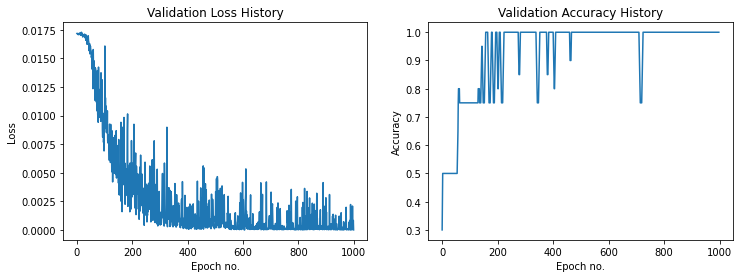

In [36]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');